<a href="https://colab.research.google.com/github/vasudevgupta7/cs4830-assignments/blob/main/lab-8/ME18B182_lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture

!sudo apt-get install openjdk-11-jdk
!pip install pyspark
!pip install -q findspark
!pip install pyarrow

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

In [3]:
import io
from pathlib import Path
import pandas as pd

import torch
from torchvision import models, transforms
from tensorflow.keras.applications.imagenet_utils import decode_predictions

from PIL import Image

import findspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, pandas_udf, regexp_extract, PandasUDFType

findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
%%capture

!wget https://www.cs.toronto.edu/%7Ekriz/cifar-10-python.tar.gz
!tar xvf cifar-10-python.tar.gz

In [5]:
!ls cifar-10-batches-py/

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


In [6]:
import pickle
import numpy as np

def prepare_cifar10_batch(dataset_batch_path):
  with open(dataset_batch_path, mode='rb') as file:
      batch = pickle.load(file, encoding='latin1')
  images = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)      
  return images, np.array(batch['labels'])

def load_cifar10_dataset(path):
  images, labels = [], []
  for batch_id in range(1, 6):
    dataset_batch_path = f"{path}/data_batch_{batch_id}"
    tmp_images, tmp_labels = prepare_cifar10_batch(dataset_batch_path)
    images.append(tmp_images)
    labels.append(tmp_labels)
  return np.concatenate(images), np.concatenate(labels)

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
from tqdm.notebook import tqdm

def write_cifar10_in_imagenet_format(images, labels, path):
  path = Path(path)
  path.mkdir(exist_ok=True)

  for label in label_names:
    (path / label).mkdir(exist_ok=True)

  for i in tqdm(range(images.shape[0])):
    data = Image.fromarray(images[i], 'RGB')
    data.save(path / label_names[labels[i]] / f'{i}.jpg')

  return path

In [8]:
path = "./cifar-10-batches-py"
images, labels = load_cifar10_dataset(path)
print(images.shape, labels.shape)

data_dir = write_cifar10_in_imagenet_format(images, labels, "cifar10_train_data")
data_dir

(50000, 32, 32, 3) (50000,)


  0%|          | 0/50000 [00:00<?, ?it/s]

PosixPath('cifar10_train_data')

In [64]:
# path = "./cifar-10-batches-py/test_batch"
# images, labels = prepare_cifar10_batch(path)

# write_cifar10_in_imagenet_format(images, labels, "cifar10_test_data")

Recursively Read all the Images from the Parent directory and create a DataFrame

In [9]:
images = spark.read.format("binaryFile").option("recursiveFileLookup", "true").option("pathGlobFilter", "*.jpg").load(str(data_dir))
print(type(images))

<class 'pyspark.sql.dataframe.DataFrame'>


In [10]:
images.show(5)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/content/cif...|2022-04-16 05:32:...|  1124|[FF D8 FF E0 00 1...|
|file:/content/cif...|2022-04-16 05:32:...|  1121|[FF D8 FF E0 00 1...|
|file:/content/cif...|2022-04-16 05:32:...|  1118|[FF D8 FF E0 00 1...|
|file:/content/cif...|2022-04-16 05:32:...|  1111|[FF D8 FF E0 00 1...|
|file:/content/cif...|2022-04-16 05:32:...|  1104|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+
only showing top 5 rows



In [12]:
regexp = f"{str(data_dir)}/([^/]+)"

def extract_label(path_col):
  """Extract label from file path using built-in SQL functions."""
  return regexp_extract(path_col, regexp, 1)

def extract_size(content):
  """Extract image size from its raw content."""
  image = Image.open(io.BytesIO(content))
  return image.size

@pandas_udf("width: int, height: int")
def extract_size_udf(content_series):
  sizes = content_series.apply(extract_size)
  return pd.DataFrame(list(sizes))

df = images.select(
  col("path"),
  col("modificationTime"),
  extract_label(col("path")).alias("label"),
  extract_size_udf(col("content")).alias("size"),
  col("content"))

df.show(5)

+--------------------+--------------------+----------+--------+--------------------+
|                path|    modificationTime|     label|    size|             content|
+--------------------+--------------------+----------+--------+--------------------+
|file:/content/cif...|2022-04-16 05:32:...|      frog|{32, 32}|[FF D8 FF E0 00 1...|
|file:/content/cif...|2022-04-16 05:32:...|      bird|{32, 32}|[FF D8 FF E0 00 1...|
|file:/content/cif...|2022-04-16 05:32:...|     truck|{32, 32}|[FF D8 FF E0 00 1...|
|file:/content/cif...|2022-04-16 05:32:...|automobile|{32, 32}|[FF D8 FF E0 00 1...|
|file:/content/cif...|2022-04-16 05:32:...|     truck|{32, 32}|[FF D8 FF E0 00 1...|
+--------------------+--------------------+----------+--------+--------------------+
only showing top 5 rows



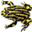

In [13]:
ima = images.select('content').rdd.map(lambda x: x.content).collect()
imgg = Image.open(io.BytesIO(ima[0]))
imgg

In [14]:
class Cifar10Dataset(torch.utils.data.Dataset):
  """
  Converts image contents into a PyTorch Dataset with standard ImageNet preprocessing.
  """
  def __init__(self, contents):
    self.contents = contents

  def __len__(self):
    return len(self.contents)

  def __getitem__(self, index):
    return self._preprocess(self.contents[index])

  def _preprocess(self, content):
    """
    Preprocesses the input image content using standard ImageNet normalization.
    
    See https://pytorch.org/docs/stable/torchvision/models.html.
    """
    image = Image.open(io.BytesIO(content))
    transform = transforms.Compose([
      transforms.Resize(256),                         ### Smaller lenght is convertd to 256 
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return transform(image)

In [15]:
def cifar10_model_udf(model):
  """
  Wraps an ImageNet model into a Pandas UDF that makes predictions.
  
  You might consider the following customizations for your own use case:
    - Tune DataLoader's batch_size and num_workers for better performance.
    - Use GPU for acceleration.
    - Change prediction types.
  """
  model.eval()
  def predict(content_series_iter : pd.Series) -> pd.DataFrame:
    for content_series in content_series_iter:                                                    # Iterates overall all Images 
      dataset = Cifar10Dataset(list(content_series))                                           
      loader = torch.utils.data.DataLoader(dataset, batch_size=64) 
      with torch.no_grad():
        for image_batch in loader:
          predictions = model(image_batch).numpy()                                                # Predictions for all 1000 classes of Mobilenetv2 Training Dataset
          predicted_labels = [x[0] for x in decode_predictions(predictions, top=1)]                       
          yield pd.DataFrame(predicted_labels)

  return_type = "class: string, desc: string, score:float"
  return pandas_udf(predict, return_type, PandasUDFType.SCALAR_ITER)

In [18]:
model = models.mobilenet_v2(pretrained=True)
cifar10 = cifar10_model_udf(model)

predictions = df.withColumn("prediction", cifar10(col("content")))
display(predictions.select(col("path"), col("prediction")).limit(5))
predictions.select(col("label"),col("prediction")).show(50, truncate=False)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


DataFrame[path: string, prediction: struct<class:string,desc:string,score:float>]

+----------+---------------------------------------+
|label     |prediction                             |
+----------+---------------------------------------+
|frog      |{n01744401, rock_python, 7.9679623}    |
|bird      |{n03944341, pinwheel, 10.355642}       |
|truck     |{n02817516, bearskin, 10.859891}       |
|automobile|{n03794056, mousetrap, 12.167225}      |
|truck     |{n03843555, oil_filter, 9.178589}      |
|truck     |{n04428191, thresher, 17.19516}        |
|frog      |{n02128925, jaguar, 11.967956}         |
|truck     |{n03796401, moving_van, 11.574023}     |
|airplane  |{n04542943, waffle_iron, 11.026524}    |
|automobile|{n03884397, panpipe, 11.6462755}       |
|frog      |{n01756291, sidewinder, 11.004475}     |
|truck     |{n02690373, airliner, 9.261075}        |
|automobile|{n03720891, maraca, 7.206638}          |
|truck     |{n04428191, thresher, 12.286238}       |
|frog      |{n03047690, clog, 9.803439}            |
|truck     |{n04428191, thresher, 13.313608}  